# Machine Learning in Brazilian ECommerce

### This notebook purpose is to use some machine learning techniques in a brazilian ecommerce dataset, and used the https://www.kaggle.com/marcelolafeta/olist-data-preparation as a start

## Natural language processing for ratings from commentaries

### Importing libraries for natural language processing (NLP)

In [1]:
import pandas as pd

import nltk
nltk.download( 'popular' )
nltk.download( 'rslp' )
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import multilabel_confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import f1_score

from xgboost import XGBClassifier

from scipy.sparse import hstack

import warnings

[nltk_data] Error loading popular: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading rslp: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


### Importing scores file

In [2]:
df_order_reviews = pd.read_csv("../input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
df_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


### Getting only the columns that will be used

In [3]:
important_columns = ['review_comment_message', 'review_comment_title', 'review_score']
df_order_reviews_imptt_cols = df_order_reviews[important_columns]
df_order_reviews_imptt_cols.head()

,review_comment_message,review_comment_title,review_score
0,NaN,NaN,4
1,NaN,NaN,5
2,NaN,NaN,5
3,Recebi bem antes do prazo estipulado.,NaN,5
4,Parabéns lojas lannister adorei comprar pela I...,NaN,5


### Dropping nan lines

In [4]:
print( 'Total of lines                         = {0:,.0f}'.format( df_order_reviews_imptt_cols.shape[0] ))
print( 'Total of lines without comment message = {0:,.0f}'.format( df_order_reviews_imptt_cols['review_comment_message'].isna().sum() ))
print( 'Total of lines without comment title   = {0:,.0f}'.format( df_order_reviews_imptt_cols['review_comment_title'].isna().sum() ))

Total of lines                         = 100,000
Total of lines without comment message = 58,247
Total of lines without comment title   = 88,285


In [5]:
#df_order_reviews_imptt_cols_na = df_order_reviews_imptt_cols.dropna(subset=['review_comment_message']).fillna({'review_comment_title':''}) # only drop messages nans and clean title
df_order_reviews_imptt_cols_na = df_order_reviews_imptt_cols.dropna(subset=['review_comment_message', 'review_comment_title']) # drop messages and titles nans

In [6]:
df_order_reviews_imptt_cols_na['review_score'].value_counts()

5    5442
1    1873
4    1441
3     756
2     474
Name: review_score, dtype: int64

In [7]:
# set the amount of records for every label
#amount = 10000
#amount = 2000
amount = df_order_reviews_imptt_cols_na.shape[0]

df = pd.DataFrame( columns=df_order_reviews_imptt_cols_na.columns )
for i in df_order_reviews_imptt_cols_na['review_score'].unique():
    df_i = df_order_reviews_imptt_cols_na[df_order_reviews_imptt_cols_na['review_score'] == i].sample(frac=1)
    df = df.append( df_i.iloc[0:amount, :] )

df['review_score'].value_counts()

5    5442
1    1873
4    1441
3     756
2     474
Name: review_score, dtype: int64

### Creating a dictionary for the words

In [8]:
warnings.filterwarnings('ignore')

# tokinize
df['tok_message'] = df.apply(lambda row: word_tokenize(row['review_comment_message'], language='portuguese'), axis=1)
df['tok_title'] = df.apply(lambda row: word_tokenize(row['review_comment_title'], language='portuguese'), axis=1)
print( 'Words examples {0}'.format( df.iloc[0, -2] ))

Words examples ['👍']


In [9]:
# remove stopwords
stw = stopwords.words('portuguese')
print( 'Stopword examples {0}'.format( stw[:8] ))

ponc = list( punctuation )
print( 'Punctuation examples {0}'.format( ponc[:8] ))

remove_words = set( stw + ponc )
df['tok_message_stw'] = df.apply(lambda row: [word for word in row['tok_message'] if word not in remove_words], axis=1)
df['tok_title_stw'] = df.apply(lambda row: [word for word in row['tok_title'] if word not in remove_words], axis=1)
print( 'Words with out stopwords examples {0}'.format( df.iloc[0, -2] ))

Stopword examples ['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da']
Punctuation examples ['!', '"', '#', '$', '%', '&', "'", '(']
Words with out stopwords examples ['👍']


In [10]:
# stemmer words
stemmer = RSLPStemmer()
df['stem_tok_message'] = df.apply(lambda row: [ stemmer.stem( word ) for word in row['tok_message_stw'] ], axis=1)
df['stem_tok_title'] = df.apply(lambda row: [ stemmer.stem( word ) for word in row['tok_title_stw'] ], axis=1)
print( 'Stemmer examples {0}'.format( df.iloc[0, -2] ))

Stemmer examples ['👍']


In [11]:
df.head()

,review_comment_message,review_comment_title,review_score,tok_message,tok_title,tok_message_stw,tok_title_stw,stem_tok_message,stem_tok_title
6304,👍,Muito bom,4,[👍],"[Muito, bom]",[👍],"[Muito, bom]",[👍],"[muit, bom]"
89854,Muito bom,Excelente,4,"[Muito, bom]",[Excelente],"[Muito, bom]",[Excelente],"[muit, bom]",[excel]
98682,"O produto em si não testei, não instalei ainda...",Entrega,4,"[O, produto, em, si, não, testei, ,, não, inst...",[Entrega],"[O, produto, si, testei, instalei, ainda, este...",[Entrega],"[o, produt, si, test, instal, aind, est, no, e...",[entreg]
89565,"Otimo produto, entrega perfeira",Super Recomendo,4,"[Otimo, produto, ,, entrega, perfeira]","[Super, Recomendo]","[Otimo, produto, entrega, perfeira]","[Super, Recomendo]","[otim, produt, entreg, perf]","[sup, recom]"
74234,"Estou satisfeita com o produto, foi entregue r...",Muito lindo !!,4,"[Estou, satisfeita, com, o, produto, ,, foi, e...","[Muito, lindo, !, !]","[Estou, satisfeita, produto, entregue, rápido]","[Muito, lindo]","[est, satisfeit, produt, entreg, rápid]","[muit, lind]"


In [12]:
# vectorize words (create dictionary)
message_words = []
title_words = []
for i in range( df.shape[0] ):
    for j in range( len(df.iloc[i, -2]) ):
        message_words.append( df.iloc[i, -2][j] )
    for j in range( len(df.iloc[i, -1]) ):
        title_words.append( df.iloc[i, -1][j] )

vectorizer_message = CountVectorizer( analyzer='word' )
vectorizer_title = CountVectorizer( analyzer='word' )

vectorizer_message.fit( message_words )
vectorizer_title.fit( title_words )

print( 'Amount of words in dictionary for messages = {0}'.format( len( vectorizer_message.vocabulary_ ) ))
print( 'Amount of words in dictionary for titles = {0}'.format( len( vectorizer_title.vocabulary_ ) ))
print( 'Dictionary for messages examples {0}'.format( list( vectorizer_message.vocabulary_)[:8] ))
print( 'Dictionary for titles examples {0}'.format( list( vectorizer_title.vocabulary_)[:8] ))


warnings.filterwarnings('default')

Amount of words in dictionary for messages = 4697
Amount of words in dictionary for titles = 1509
Dictionary for messages examples ['muit', 'bom', 'produt', 'si', 'test', 'instal', 'aind', 'est']
Dictionary for titles examples ['muit', 'bom', 'excel', 'entreg', 'sup', 'recom', 'lind', 'ant']


### Preparing the data

In [13]:
messages = df['review_comment_message'].values #X1
titles = df['review_comment_title'].values #X2
scores = df['review_score'].values #Y
scores -= 1 # transform values 1 to 5, to 0 to 4 

print( 'Total number of lines = {0}'.format( messages.shape[0] ))

Total number of lines = 9986


In [14]:
scores_dummy = np_utils.to_categorical(scores)
size_scores = len(scores_dummy[0])
print( 'Scores examples = {0}'.format( scores[:5] ))
print( 'Dummy scores examples = {0}'.format( scores_dummy[:5] ))

Scores examples = [3 3 3 3 3]
Dummy scores examples = [[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [15]:
x_train_m, x_test, y_train, y_test = train_test_split( messages, scores_dummy, test_size=0.3, random_state=42 )
x_val_m, x_test_m, y_val, y_test = train_test_split( x_test, y_test, test_size=0.5, random_state=42 )
x_train_t, x_test, y_train, y_test = train_test_split( titles, scores_dummy, test_size=0.3, random_state=42 )
x_val_t, x_test_t, y_val, y_test = train_test_split( x_test, y_test, test_size=0.5, random_state=42 )

print('Total number of lines for training   = {0}'.format( x_train_m.shape ))
print('Total number of lines for validation = {0}'.format( x_val_m.shape ))
print('Total number of lines for testing    = {0}'.format( x_test_m.shape ))

Total number of lines for training   = (6990,)
Total number of lines for validation = (1498,)
Total number of lines for testing    = (1498,)


In [16]:
bow_x_train_m = vectorizer_message.transform( x_train_m )
bow_x_train_t = vectorizer_title.transform( x_train_t )
bow_x_train = hstack([bow_x_train_m, bow_x_train_t], format='csr') # join the two bows
#bow_x_train = bow_x_train_m # use only the commentaries

bow_x_val_m = vectorizer_message.transform( x_val_m )
bow_x_val_t = vectorizer_title.transform( x_val_t )
bow_x_val = hstack([bow_x_val_m, bow_x_val_t], format='csr') # join the two bows
#bow_x_val = bow_x_val_m # use only the commentaries

bow_x_test_m = vectorizer_message.transform( x_test_m )
bow_x_test_t = vectorizer_title.transform( x_test_t )
bow_x_test = hstack([bow_x_test_m, bow_x_test_t], format='csr') # join the two bows
#bow_x_test = bow_x_test_m # use only the commentaries

print('Bag of words format for training   = {0}'.format( bow_x_train.shape ))
print('Bag of words format for validation = {0}'.format( bow_x_val.shape ))
print('Bag of words format for testing    = {0}'.format( bow_x_test.shape ))

Bag of words format for training   = (6990, 6206)
Bag of words format for validation = (1498, 6206)
Bag of words format for testing    = (1498, 6206)


### Creating the model

In [17]:
model = Sequential()

#model.add( Dense( 2048, activation='relu', input_shape=( bow_x_train.shape[1], )))
model.add( Dense( 1024, activation='relu', input_shape=( bow_x_train.shape[1], )))
#model.add( Dense( 256, activation='relu', input_shape=( bow_x_train.shape[1], )))
#model.add( Dense( 64, activation='relu', input_shape=( bow_x_train.shape[1], )))
#model.add( Dense( 32, activation='relu' ))
#model.add( Dense( 16, activation='relu' ))
#model.add( Dense( 8, activation='relu' ))

model.add( Dense( size_scores, activation='softmax' ))

model.compile( Adam(), loss='categorical_crossentropy', metrics=['accuracy'] )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              6355968   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 6,361,093
Trainable params: 6,361,093
Non-trainable params: 0
_________________________________________________________________


### Training the model

In [18]:
history = model.fit( bow_x_train, y_train, epochs=5, validation_data=( bow_x_val, y_val ))

Epoch 1/5
219/219 [==============================] - 3s 15ms/step - loss: 0.8962 - accuracy: 0.6884 - val_loss: 0.8408 - val_accuracy: 0.6836
Epoch 2/5
219/219 [==============================] - 3s 14ms/step - loss: 0.7011 - accuracy: 0.7432 - val_loss: 0.8672 - val_accuracy: 0.6789
Epoch 3/5
219/219 [==============================] - 3s 14ms/step - loss: 0.5972 - accuracy: 0.7831 - val_loss: 0.9164 - val_accuracy: 0.6622
Epoch 4/5
219/219 [==============================] - 3s 15ms/step - loss: 0.4938 - accuracy: 0.8232 - val_loss: 0.9806 - val_accuracy: 0.6602
Epoch 5/5
219/219 [==============================] - 3s 14ms/step - loss: 0.4080 - accuracy: 0.8582 - val_loss: 1.0358 - val_accuracy: 0.6502


### Evaluating the model

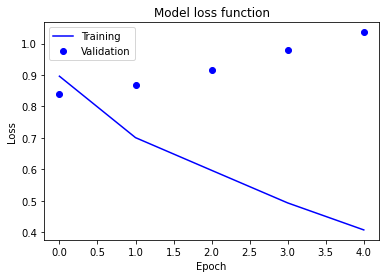

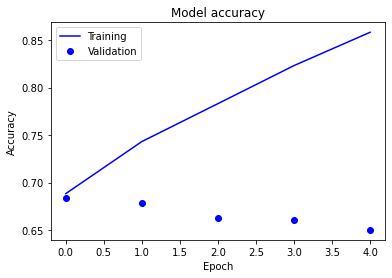

In [19]:
plt.plot( history.history['loss'], 'b', label='Training' )
plt.plot( history.history['val_loss'], 'bo', label='Validation' )
plt.title( 'Model loss function' )
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.legend()
plt.show()

plt.plot( history.history['accuracy'], 'b', label='Training' )
plt.plot( history.history['val_accuracy'], 'bo', label='Validation' )
plt.title( 'Model accuracy' )
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.legend()
plt.show()

In [20]:
train_metrics = model.evaluate( bow_x_train, y_train )
print('Loss function in train = {0:.4f}\nAccuracy in train = {1:.4f}'.format( train_metrics[0], train_metrics[1] ))

val_metrics = model.evaluate( bow_x_val, y_val )
print('Loss function in validation = {0:.4f}\nAccuracy in validation = {1:.4f}'.format( val_metrics[0], val_metrics[1] ))

test_metrics = model.evaluate( bow_x_test, y_test )
print('Loss function in test = {0:.4f}\nAccuracy in test = {1:.4f}'.format( test_metrics[0], test_metrics[1] ))

219/219 [==============================] - 0s 1ms/step - loss: 0.3255 - accuracy: 0.8920
Loss function in train = 0.3255
Accuracy in train = 0.8920
47/47 [==============================] - 0s 2ms/step - loss: 1.0358 - accuracy: 0.6502
Loss function in validation = 1.0358
Accuracy in validation = 0.6502
47/47 [==============================] - 0s 2ms/step - loss: 0.9984 - accuracy: 0.6762
Loss function in test = 0.9984
Accuracy in test = 0.6762


In [21]:
predict_train = np.argmax( model.predict( bow_x_train ), axis=1 )
predict_val = np.argmax( model.predict( bow_x_val ), axis=1 )
predict_test = np.argmax( model.predict( bow_x_test ), axis=1 )

print( 'F1 Score for NN in training   = {0:.4f}'.format( f1_score( np.argmax( y_train, axis=1 ), predict_train, average='weighted' )))
print( 'F1 Score for NN in validation = {0:.4f}'.format( f1_score( np.argmax( y_val, axis=1 ), predict_val, average='weighted' )))
print( 'F1 Score for NN in testing    = {0:.4f}'.format( f1_score( np.argmax( y_test, axis=1 ), predict_test, average='weighted' )))

F1 Score for NN in training   = 0.8826
F1 Score for NN in validation = 0.6009
F1 Score for NN in testing    = 0.6242


In [22]:
y_pred = model.predict( bow_x_test )
y_pred = np.round( y_pred )

conf_matrix = multilabel_confusion_matrix( y_test, y_pred )
conf_matrix

array([[[1147,   71],
        [ 101,  179]],

       [[1403,   27],
        [  59,    9]],

       [[1366,   22],
        [ 102,    8]],

       [[1241,   25],
        [ 217,   15]],

       [[ 475,  215],
        [  68,  740]]])

In [23]:
test1_m = 'Não gostei e nunca vou recomendar'
test1_t = 'Horrível'

test2_m = 'Não assistiria de novo'
test2_t = 'Bem fraco'

test3_m = 'Não impressiona nem decepciona'
test3_t = 'Mais ou menos'

test4_m = 'Achei bem bacana'
test4_t = 'Bom'

test5_m = 'Pretendo assistir mais vezes de tão bom'
test5_t = 'Maravilhoso'

test_list_m = [ test1_m, test2_m, test3_m, test4_m, test5_m ]
test_list_t = [ test1_t, test2_t, test3_t, test4_t, test5_t ]

test_vec_m = vectorizer_message.transform( test_list_m )
test_vec_t = vectorizer_title.transform( test_list_t )
test_vec = hstack( [test_vec_m, test_vec_t], format='csr' ) # join the two bows

test_pred = model.predict( test_vec )

test_pred_max = np.argmax( test_pred, axis=1 ) + 1

for i in range( len(test_list_m) ):
    print('Test {0} model predicted {1}'.format( i, test_pred_max[i] ))

Test 0 model predicted 5
Test 1 model predicted 1
Test 2 model predicted 2
Test 3 model predicted 5
Test 4 model predicted 5


### Trying different models

In [24]:
x_train, x_test, y_train, y_test = train_test_split( messages, scores, test_size=0.3, random_state=42 )
x_val, x_test, y_val, y_test = train_test_split( x_test, y_test, test_size=0.5, random_state=42 )

y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

In [25]:
# Multinomial Naive Bayes
nb_clf = MultinomialNB()
nb_clf.fit( bow_x_train, y_train )

MultinomialNB()

In [26]:
predict_train = nb_clf.predict( bow_x_train )
predict_val = nb_clf.predict( bow_x_val )
predict_test = nb_clf.predict( bow_x_test )

print( 'F1 Score for MNB in training   = {0:.4f}'.format( f1_score( y_train, predict_train, average='weighted' )))
print( 'F1 Score for MNB in validation = {0:.4f}'.format( f1_score( y_val, predict_val, average='weighted' )))
print( 'F1 Score for MNB in testing    = {0:.4f}'.format( f1_score( y_test, predict_test, average='weighted' )))

F1 Score for MNB in training   = 0.6372
F1 Score for MNB in validation = 0.5769
F1 Score for MNB in testing    = 0.6012


In [27]:
# Support Vector Machines Multi-class Classification
svm_clf = svm.SVC()
svm_clf.fit( bow_x_train, y_train )

SVC()

In [28]:
predict_train = svm_clf.predict( bow_x_train )
predict_val = svm_clf.predict( bow_x_val )
predict_test = svm_clf.predict( bow_x_test )

print( 'F1 Score for SVM in training   = {0:.4f}'.format( f1_score( y_train, predict_train, average='weighted' )))
print( 'F1 Score for SVM in validation = {0:.4f}'.format( f1_score( y_val, predict_val, average='weighted' )))
print( 'F1 Score for SVM in testing    = {0:.4f}'.format( f1_score( y_test, predict_test, average='weighted' )))

F1 Score for SVM in training   = 0.7764
F1 Score for SVM in validation = 0.5751
F1 Score for SVM in testing    = 0.6021


In [29]:
# XGBoost Classifier
xgb_clf = XGBClassifier(learning_rate = 0.01,
                         max_depth = 10, 
                         n_estimators = 1000,
                         objective = 'binary:logistic',
                         verbosity =0,
                         seed = 42,
                         reg_lambda = 8,
                         reg_alpha = 2,
                         gamma = 5,
                         subsample= 0.8,
                         #tree_method = 'gpu_hist'
                         )
xgb_clf.fit( bow_x_train, y_train )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=2,
              reg_lambda=8, scale_pos_weight=None, seed=42, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [30]:
predict_train = xgb_clf.predict( bow_x_train )
predict_val = xgb_clf.predict( bow_x_val )
predict_test = xgb_clf.predict( bow_x_test )

print( 'F1 Score for XGB in training   = {0:.4f}'.format( f1_score( y_train, predict_train, average='weighted' )))
print( 'F1 Score for XGB in validation = {0:.4f}'.format( f1_score( y_val, predict_val, average='weighted' )))
print( 'F1 Score for XGB in testing    = {0:.4f}'.format( f1_score( y_test, predict_test, average='weighted' )))

F1 Score for XGB in training   = 0.6182
F1 Score for XGB in validation = 0.5844
F1 Score for XGB in testing    = 0.5889


## Unsupervised learning for clustering sellers

## Supervised Learning to predict customer revenue

## Supervised Learning to predict product sale quantity